# Functions

In [9]:
#Function to show the plot from paper
def showPlot(df, improvement_overall):
    '''
    df: DataFrame with all the parameters to plot (birth; predict_base; predict_trend)
    improvement_overall: value of the improvement
    '''
    
    #Defining the overall parameters for the figure
    params = {'legend.fontsize': 20,
              'legend.handlelength': 3,
              'figure.figsize': (15,10),
              'axes.labelsize' : 15,
              'xtick.labelsize' : 15,
              'ytick.labelsize' : 15}
    plt.rcParams.update(params) #applying them

    #plotting each curve with specific parameters
    fig, ax = plt.subplots()
    ax.plot(df.birth, 'k', linewidth=2, label='Actual') #Thicker line for the real data
    ax.plot(df.predict_base, 'k--', linewidth=1,label='Base') #Doted line for the predicted curve with basic data
    ax.plot(df.predict_trend, 'k', linewidth=1, label='Trends') #Classic line for the predicted curve with basic + trend data

    #Defining figure title
    plt.suptitle('Births in France', fontsize=20)

    #Defining (x;y) labels
    plt.xlabel('Index')
    plt.ylabel('log(mvp)')

    #Plotting the legend
    plt.legend(loc="upper right")

    #Creating the box with the MAE improvements
    textstr = '\n'.join((
        r'MAE improvement',
        r'Overall = $%.1f$%%' % (improvement_overall, )))
    ax.text(0.013, 0.135, textstr, transform=ax.transAxes, fontsize=17.5,
            verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', pad=10))

    #Showing the plot
    plt.show
    return
    

#10 best features selection based on its correlation with the birth number
def bestFeatureCorrelation(date, k):
    '''
    date: date at which we want to determine the correlation
    k: size of the data we want to check the correlation on (size recommended: identical to the ORLS)
    '''    
    
    #Number of month in which we should look for correlation before choosing the best (size of the rolling ols)
    pearson = [] #df in which we store the pearson correlation factor
    kendall = [] #df in which we store the kendall correlation factor
    spearman = [] #df in which we store the spearman correlation factor
    
    date = single_date.strftime("%Y-%m-%d")
    end_date = datetime.strptime(date, '%Y-%m-%d')  
    start_date = end_date - relativedelta(months=+k)

    end_date = datetime.strftime(end_date, '%Y-%m-%d')
    start_date = datetime.strftime(start_date, '%Y-%m-%d')

    temp_df=pd.DataFrame(GTD_df.loc[start_date:end_date], dtype='float') #Taking the time index that are also in the birth_df
    birth_temp = pd.DataFrame(birth_df.loc[start_date:end_date], dtype='float')
    for i,j in enumerate(categories_df['id']):

        if str(j) in temp_df.columns:
            #Pearson correlation calculation
            pearsonTemp = np.abs(birth_temp.iloc[:,0].corr(temp_df[str(j)],method='pearson'))
            pearson.append(pearsonTemp)
            #Kendall correlation calculation
            kendallTemp = np.abs(birth_temp.iloc[:,0].corr(temp_df[str(j)],method='kendall'))       
            kendall.append(kendallTemp)
            #Spearman correlation calculation
            spearmanTemp = np.abs(birth_temp.iloc[:,0].corr(temp_df[str(j)],method='spearman'))
            spearman.append(spearmanTemp)

        else:
            #if the correlation could not be calculated -> put NaN
            pearson.append(np.nan)
            kendall.append(np.nan)
            spearman.append(np.nan)

    #Normalizing our correlation indicators in order to combine them and compare them
    pearsonNorm = 100 / np.nanmax(pearson)
    categories_df['Pearson'] = np.multiply(pearsonNorm, pearson)
    kendallNorm = 100 / np.nanmax(kendall)    
    categories_df['Kendall'] = np.multiply(kendallNorm, kendall)
    spearmanNorm = 100 / np.nanmax(spearman)
    categories_df['Spearman'] = np.multiply(spearmanNorm, spearman)

    #Crossing between our correlations to see which feature is the best
    cal = pd.DataFrame([categories_df["Spearman"], categories_df["Pearson"], categories_df["Kendall"]]).transpose()
    cal = cal.mean(axis=1)
    categories_df['Mean'] = cal

    #Displaying the 10 best
    categories_best = categories_df.sort_values('Mean', ascending=False).iloc[0:20,:].reset_index(drop=True)
    return  categories_best

def prediction(date,k,birth_df,GTD,ids):
    '''
    date: dates at which we want to predict
    k: size of the rolling windows
    df: birth df
    temp_GTD: Google Trends DF
    ids.: ids of category
    '''
    
    df = birth_df.copy()
    temp_GTD = GTD_df.copy()
    
    end = datetime.strptime(date, '%Y-%m-%d')  
    start = end - relativedelta(months=+k)
    end = datetime.strftime(end, '%Y-%m-%d')
    start = datetime.strftime(start, '%Y-%m-%d')
    
    df = df.loc[start:end]
    temp_GTD = temp_GTD.loc[start:end]
    
    #Features selection
    formula = str('birth ~ birth_6 + birth_12')
    columns_name = ['b0','b1','b2']
    for j,i in enumerate(ids):
        df["y%d"%j] = temp_GTD.loc[:,str(int(i))]
        formula = formula + ' + ' + str("y%d"%j)
        columns_name.append(str("b%d"%(j+ 3)))
        #GTD_df.loc[:,str(categories_best.id[i])]

    index_date = df.index #saving the index for later plotting
    df = df.reset_index(drop=True) #Resetting the index to [0-n] format


    res_base = RollingOLS.from_formula('birth ~ birth_6 + birth_12', data=df, window=k).fit() #We use our rolling windows function
    params = pd.DataFrame(res_base.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = ['a0','a1','a2'] #Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_base'] = df.a0 + df.a1*df.birth_6 + df.a2*df.birth_12 #predicting the values for the next month

    res_trend = RollingOLS.from_formula(formula, data=df, window=k).fit()#We use our rolling windows function
    params = pd.DataFrame(res_trend.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = columns_name#Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_trend'] = df.b0 + df.b1*df.birth_6 + df.b2*df.birth_12 
    for j,i in enumerate(ids):
        df['predict_trend'] = df['predict_trend'] + params.iloc[:,3+j]*  df.iloc[:,3+j]  #predicting the values for the next month


    #add date index again
    df.index = index_date

    #MAE + Improvement overall calculation between the base fit and base+trend fit
    mae_base = np.mean(abs(df.birth-df.predict_base))*100
    mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
    improvement_overall = (mae_base-mae_trends)*100 /mae_base
    return df,improvement_overall


#Function to return all the value in the date range
def dateRange(start_date, end_date,k):
    '''
    start_date: start date of the date range
    end_date: end date of the date range
    '''
    for n in range(k, rep):#GTD_df.shape[0]):
        yield start_date + relativedelta(months=n)

#Function to standardize data
def standardize(data):
    mean_x = np.mean(data)
    std_x = np.std(data)
    x = data
    x = x - mean_x
    for i in range (len(std_x)):
        if std_x[i] == 0:
            std_x[i]=1
    x = x / std_x
    return x

#Count frequency
def CountFrequency(my_list): 
  
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
    
    return freq


# TODO / Commentaire
 - Est ce qu'on met en log les births ?
 - 
 
 use of contraceptive method
 abortion
 impact of emmigration
 children as workpower

# Wesh les reufs bien ou quoi

Importing data:
 - `valeurs_mensuelles.csv`: containing the number of birth in France for each month from 01-01-2004 to 01-10-2020.<br>
 Columns:
     - Période: month
     - Démographie - Nombre de naissances vivantes - France métropolitaine: number of birth for the corresponding month
     - Codes: Codes for explaining what type of value we have in our case we have "P" for 2020 data standing for "provisional" and "A" everywhere else standing for normale value. (see `caract.csv` for further details)
 - `GTD.csv`: containing the query number of google trend data for different categories.<br>
   This dataframe is created in the notebook `GTD_preprocessing.ipynb`.<br>
 Columns:
     - date: date of the query number
     - category id : columns containing all the query number in France for this category.
     
 - `categories.csv`: containing all the ids and names of the google trend categories<br>
   This dataframe is created in the notebook `GTD_preprocessing.ipynb`. The categories can be seen as a list with sub-categories here: https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories<br>
 Columns:
     - id: id of the diffrent category
     - name: Name of this category

In [10]:
#***Attention***  les donnees n'ont pas les memes tailles
#valeurs mensuelle = 202x1        01-01-2004  --> 01-10-2020 
#GTD               = 204×916      01-01-2004  --> 01-12-2020       916 categories       (donnée incomplete pour decembre)    (certaines categories ne donne pas de resultat exemple : category 42 "jazz" https://trends.google.com/trends/explore?cat=42&date=all&geo=FR )
# categories       = 1133x3                                       1133 categories       (il y a bien 1133 category differentes sur google trend mais dans GTD on a enlevé les category sans resultat  il en reste 916)

# 1- Importing DATA

In [11]:
# Importing librairies: numpy, matplotlib, pandas, statmodel
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from dateutil.relativedelta import relativedelta
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from numpy import linalg as LA

In [12]:
# Importing birth data with selecting correct columns and changing columns names
data_folder = './Data/'
birth_df = pd.read_csv(data_folder +'valeurs_mensuelles.csv', sep= ';', index_col= 0, skiprows=2, usecols=[0,1],header=0, names=['Période','birth'])

# Changing indexes to panda date
birth_df.index = pd.to_datetime(birth_df.index)

# Putting sales data in log scale as we want
birth_df['birth'] = birth_df['birth'].apply(np.log)

# Getting an overview
birth_df = birth_df.sort_index()
birth_df

,birth
Période,
2004-01-01,11.067248
2004-02-01,10.989048
2004-03-01,11.018383
2004-04-01,11.020529
2004-05-01,11.026028
...,...
2020-06-01,10.978490
2020-07-01,11.044521
2020-08-01,11.008744


In [17]:
# Importing google trend data
GTD_df = pd.read_csv(data_folder +'GTD.csv',index_col= 0)
GTD_df.head(10)

# Getting an overview
GTD_df = GTD_df.loc['2004-01-01':'2020-10-01']
col = pd.to_numeric(GTD_df.columns)
GTD_df = standardize(GTD_df)
GTD_df.head(10)

,0,3,5,7,8,11,12,13,14,16,...,1381,1385,1386,1387,1388,1389,1390,1391,1392,1397
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,5.249401,-0.286742,1.946000,-1.837663,-0.099506,-2.317342,0.415269,-0.039441,0.549825,-1.000649,...,-1.039552,2.105135,0.870921,0.312119,-0.637383,-0.615030,-0.842779,1.832274,1.631805,0.049782
2004-02-01,2.377302,-0.286742,1.734501,-1.736351,-0.099506,-2.694034,0.415269,-0.272394,0.083493,-1.295731,...,-1.039552,3.883694,1.687456,2.399076,1.952096,1.302193,1.318254,1.650784,2.426081,-0.210737
2004-03-01,1.573114,-0.167806,1.776801,-1.027165,-0.146800,-2.317342,0.643629,-0.086031,0.472103,-0.803928,...,-1.119003,1.242803,1.613226,0.531799,1.590774,-0.167678,-2.363506,1.711280,1.548197,-0.210737
2004-04-01,0.194507,-0.108338,1.776801,-1.331102,-0.004917,-1.815085,0.719749,-0.272394,0.394381,-1.000649,...,-1.079277,3.236945,4.433983,1.849877,2.192978,2.260804,-1.002856,1.469293,2.676905,-0.210737
2004-05-01,2.377302,-0.108338,1.819101,-2.242912,-0.052211,-1.815085,0.491389,-0.086031,0.394381,-0.803928,...,-1.079277,-0.751338,1.613226,0.751479,0.326144,1.238285,2.518828,0.985319,1.840825,0.310302
2004-06-01,-0.954333,-0.048870,1.776801,-1.635039,0.089672,-1.689521,0.948109,0.053741,0.472103,-0.803928,...,-1.079277,1.081116,1.613226,3.167955,0.807908,2.580341,-0.442588,1.892771,2.133453,0.622925
2004-07-01,1.917766,-0.346210,1.565302,-1.533727,-0.052211,-1.940649,0.186909,0.007150,-0.227394,-1.197371,...,-1.039552,1.188908,-2.172527,0.971158,1.169231,1.430007,-1.803239,2.013764,2.593297,0.206094
2004-08-01,0.654042,-0.524614,1.396103,-2.141600,-0.004917,-1.689521,-0.498172,-0.225803,-0.382838,-1.492453,...,-1.039552,0.649950,0.277078,0.092439,-1.179367,1.302193,-2.283468,0.682835,2.342473,-0.158633
2004-09-01,2.032650,-0.227274,1.946000,-1.027165,-0.052211,-1.312829,1.100349,0.426465,0.394381,-1.394092,...,-1.039552,3.398632,2.281300,0.531799,2.253198,0.151859,1.638407,1.711280,1.339177,-0.106529


In [18]:
# Importing google trend categories
categories_df = pd.read_csv(data_folder +'categories.csv',index_col= 0)

# Keeping only the elements of interest and getting an overview
categories_df = categories_df[categories_df['id'].isin(col)]
categories_df

,id,name
1426,0,Toutes catégories
240,3,Arts et divertissements
715,5,Informatique et électronique
396,7,Finance
785,8,Jeux
...,...,...
1415,1389,Agritourisme
1418,1390,Visites touristiques
1417,1391,Oenotourisme
1412,1392,Offices du tourisme et syndicats d'initiative


## Analyse des categories et selection

start_date, end_date: start and end date of the total period

 
best_selection = 
 - 1: par correlation
 - 2: par improvement solo
 - 3: par improvement solo on the last shift months ex 12 best improvements on the lasts 12 months

 
Remove_seasonnality = 
 - 0: no
 - 1 : yes
 
nb_category_prediction: number of category used for prediction (1-20)

In [19]:
start_date = '2004-01-01' #'2015-01-01'   #'2004-01-01'
end_date = '2005-01-01'

normalisation_GTD = 1
 
best_selection = 3
shift = 1
 
Remove_seasonnality = 0
 
nb_category_prediction = 3

k = 17

# do not touch 
months_shift = k+shift

In [20]:
birth_df

,birth
Période,
2004-01-01,11.067248
2004-02-01,10.989048
2004-03-01,11.018383
2004-04-01,11.020529
2004-05-01,11.026028
...,...
2020-06-01,10.978490
2020-07-01,11.044521
2020-08-01,11.008744


### Seasonnality


<AxesSubplot:xlabel='Période'>

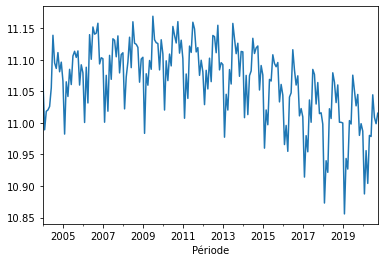

In [21]:
from statsmodels.tsa.seasonal import STL
if Remove_seasonnality == 1:
    birth = STL(birth_df.birth).fit()
    birth_df['birth'] = birth_df['birth'] - birth.seasonal
    
birth_df['birth'].plot()

### Shifting columns

In [22]:
nan = np.empty(6)
nan[:] = 0
birth_df['birth_6'] =  [*nan , *birth_df.birth[:-6].values] # Moving down 6 rows and putting 0 in the empty space
nan = np.empty(12)
nan[:] = 0
birth_df['birth_12'] =  [*nan , *birth_df.birth[:-12].values] # Moving down 12 rows and putting 0 in the empty space 

In [23]:
GTD_df

,0,3,5,7,8,11,12,13,14,16,...,1381,1385,1386,1387,1388,1389,1390,1391,1392,1397
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,5.249401,-0.286742,1.946000,-1.837663,-0.099506,-2.317342,0.415269,-0.039441,0.549825,-1.000649,...,-1.039552,2.105135,0.870921,0.312119,-0.637383,-0.615030,-0.842779,1.832274,1.631805,0.049782
2004-02-01,2.377302,-0.286742,1.734501,-1.736351,-0.099506,-2.694034,0.415269,-0.272394,0.083493,-1.295731,...,-1.039552,3.883694,1.687456,2.399076,1.952096,1.302193,1.318254,1.650784,2.426081,-0.210737
2004-03-01,1.573114,-0.167806,1.776801,-1.027165,-0.146800,-2.317342,0.643629,-0.086031,0.472103,-0.803928,...,-1.119003,1.242803,1.613226,0.531799,1.590774,-0.167678,-2.363506,1.711280,1.548197,-0.210737
2004-04-01,0.194507,-0.108338,1.776801,-1.331102,-0.004917,-1.815085,0.719749,-0.272394,0.394381,-1.000649,...,-1.079277,3.236945,4.433983,1.849877,2.192978,2.260804,-1.002856,1.469293,2.676905,-0.210737
2004-05-01,2.377302,-0.108338,1.819101,-2.242912,-0.052211,-1.815085,0.491389,-0.086031,0.394381,-0.803928,...,-1.079277,-0.751338,1.613226,0.751479,0.326144,1.238285,2.518828,0.985319,1.840825,0.310302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-01,0.194507,-1.476101,-0.930386,-0.520604,-1.139985,3.207479,-0.422052,-1.483749,-0.849169,0.868203,...,0.152216,-0.751338,-0.613687,-0.127240,-0.516942,-0.487215,0.597910,-0.466604,-0.876435,-0.992295
2020-07-01,-0.839449,-1.595037,-1.014986,-1.229790,-1.187279,1.826274,-0.878772,-1.576930,-1.082335,-0.017043,...,0.033039,-0.859130,-1.059070,-0.566600,0.025042,-0.295493,0.597910,-0.527101,-0.542003,-1.148607
2020-08-01,-1.184101,-1.476101,-1.057286,-1.938975,-1.139985,1.575146,-1.107132,-1.670111,-1.237779,0.474761,...,0.033039,-1.020817,-1.281761,-0.786279,-0.998705,-0.359400,0.838024,-0.224617,-0.583807,-1.096503


# 2- Model with correlation

In [24]:
#Data for correlation
start_date = '2004-01-01' 
end_date = '2020-11-01'
k = 18

#Date processing
start_date = datetime.strptime(start_date, '%Y-%m-%d')  
end_date = datetime.strptime(end_date, '%Y-%m-%d')
rep = len(pd.date_range(start_date,end_date, freq='M'))

#output dataframe for the best parameters
best = pd.DataFrame()

#Loop in which we find the best hyper parameters with correlation
for single_date in dateRange(start_date, end_date, k):
    date = single_date.strftime("%Y-%m-%d")
    corr = bestFeatureCorrelation(date, k)
    best[date]=corr.id[0:10]
    if single_date.month == 1:
        print(date)

C:\Users\pierr\anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


2006-01-01
2007-01-01
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
2014-01-01
2015-01-01
2016-01-01
2017-01-01
2018-01-01
2019-01-01
2020-01-01


In [25]:
imp = []
base = []
trend = []
birth = []

#Predicting the values for each date

for single_date in dateRange(start_date, end_date, k):
    date = single_date.strftime("%Y-%m-%d")
    aze, impt = prediction(date,k,birth_df,GTD_df,best[date][0:1]) #Predicting    
    birth.append(aze['birth'][-1]) #Real data
    base.append(aze['predict_base'][-1]) #Base prediction
    trend.append(aze['predict_trend'][-1]) #Trend prediction 
    imp.append(impt) #improvement for the date
    
    if single_date.month == 1:
        print(date)

2006-01-01
2007-01-01
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
2014-01-01
2015-01-01
2016-01-01
2017-01-01
2018-01-01
2019-01-01
2020-01-01


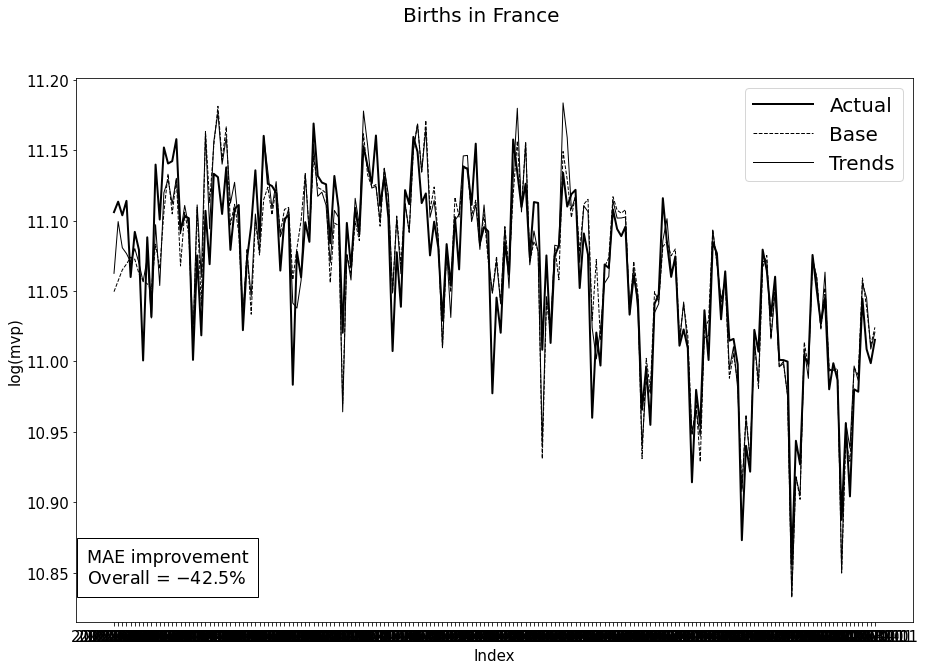

In [26]:
df = pd.DataFrame(index = best.columns)
df["birth"]=birth
df["predict_base"]=base
df["predict_trend"]=trend
improvement_overall = np.mean(imp)

showPlot(df, improvement_overall)

In [35]:
categories_df = categories_df.set_index(categories_df.id, drop= True)

categories_best_1 = pd.DataFrame(categories_df.loc[best.loc[0,:].values, "name"])
categories_best = categories_best_1

categories_best_2 = pd.DataFrame(categories_df.loc[best.loc[1,:].values, "name"])
categories_best = categories_best.append(categories_best_2, ignore_index=True)

categories_best_3 = pd.DataFrame(categories_df.loc[best.loc[2,:].values, "name"])
categories_best = categories_best.append(categories_best_3, ignore_index=True)

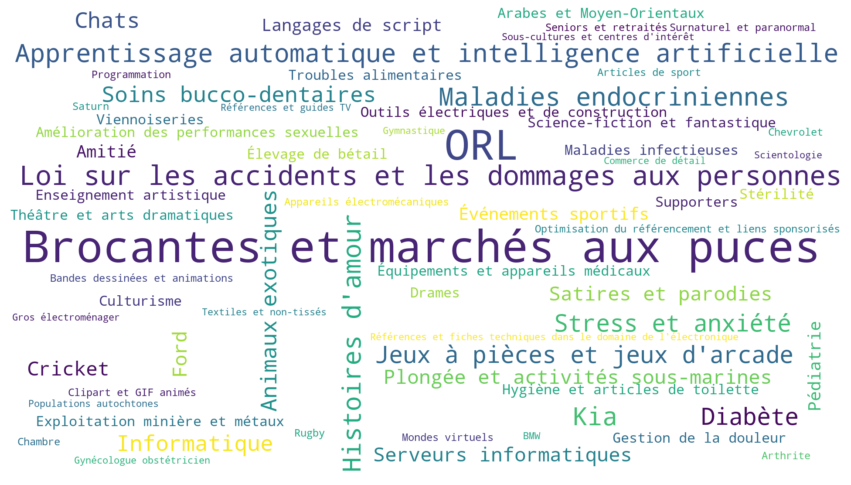

In [36]:
#Occurence with best correlation n°1
s = CountFrequency(categories_best_1['name'])

text = ("+").join(categories_best['name'])

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1920, height=1080,background_color="white").generate_from_frequencies(s)   #regexp=r"\w[\w' ]+"

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
#text

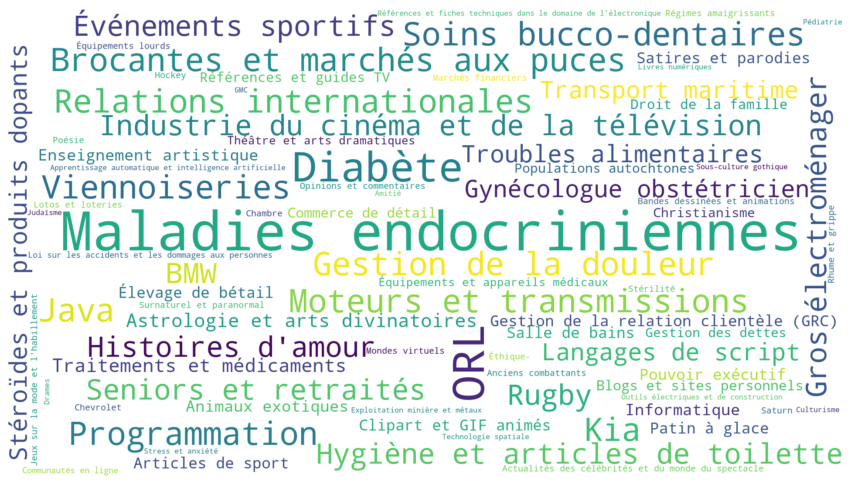

In [39]:
#Occurence with best correlation n°2
s = CountFrequency(categories_best_2['name'])

text = ("+").join(categories_best['name'])

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1920, height=1080,background_color="white").generate_from_frequencies(s)   #regexp=r"\w[\w' ]+"

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
#text

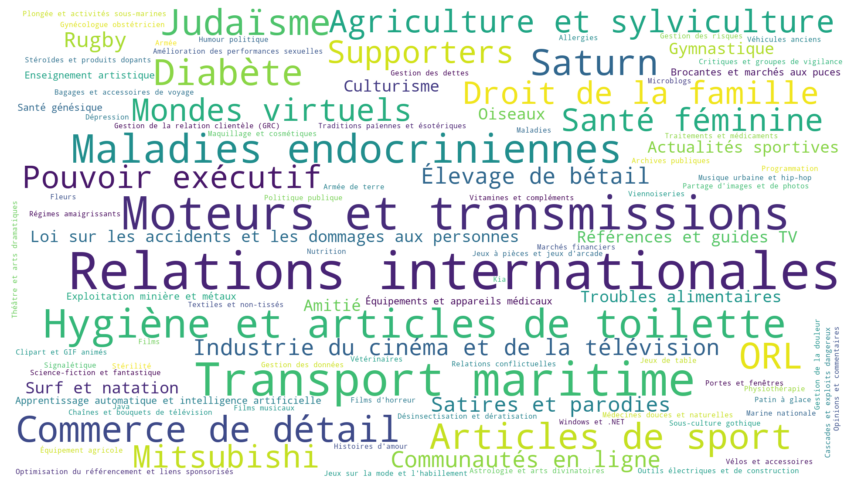

In [38]:
#Occurence with best correlation n°3
s = CountFrequency(categories_best_3['name'])

text = ("+").join(categories_best['name'])

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1920, height=1080,background_color="white").generate_from_frequencies(s)   #regexp=r"\w[\w' ]+"

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
#text

## improvement function

In [ ]:
#size of the rolling window = 17 = 4 mois ds le précédent paper, on prend 6 dans celui là comme en plus on a une saisonnalité de 6 mois
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5269518/
def best_feature_improvement(k,start = start_date, end = end_date):
    '''
    Input: 
        -start: start date in format '2004-01-01'
        -end: end date in format '2020-10-01'
        k: rolling windows size, recommended size : 6
    '''


    improvement = []

    #Checking for each feature
    for i in GTD_df.columns:

        #Setting the dfs
        df = birth_df.copy()
          

        #Setting the feature of interest
        df[str("y0")] = GTD_df[str(i)]
        df = df.loc[start:end]
        df = df.reset_index(drop=True) #Resetting the index to [0-n] format

        #Basic reg
        res_base = RollingOLS.from_formula('birth ~ birth_6 + birth_12', data=df, window=k).fit() #We use our rolling windows function
        params = pd.DataFrame(res_base.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
        params.columns = ['a0','a1','a2'] #Changing the parameters' columns names
        df = pd.concat([df, params], axis=1) #adding it to our dataframe
        df['predict_base'] = df.a0 + df.a1*df.birth_6 + df.a2*df.birth_12 #predicting the values for the next month

        #Trend reg with feature of interest
        res_trend = RollingOLS.from_formula('birth ~ birth_6 + birth_12 + y0', data=df, window=k).fit()#We use our rolling windows function
        params = pd.DataFrame(res_trend.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
        params.columns = ['b0','b1','b2','b3']#Changing the parameters' columns names
        df = pd.concat([df, params], axis=1) #adding it to our dataframe
        df['predict_trend'] = df.b0 + df.b1*df.birth_6 + df.b2*df.birth_12 + df.b3 * df.y0   #predicting the values for the next month

        #Calculating MAE and Improvement
        mae_base = np.mean(abs(df.birth-df.predict_base))*100
        mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
        improvement_overall = (mae_base-mae_trends)*100 /mae_base
        improvement.append(improvement_overall)


    #Our df well ordered
    categories_best = categories_df.reset_index(drop=True)
    categories_best['Improvement'] = pd.DataFrame(improvement)
    categories_best = categories_best.sort_values('Improvement', ascending=False)
    categories_best = categories_best.reset_index(drop=True)
    
    return categories_best

### improvement solo 

In [ ]:
if best_selection==2:
    # IMPROVEMENT
    categories_best = best_feature_improvement(k)
    
    # Create the dataframe with GTD
    predict_gtd = pd.DataFrame(index = birth_df.index)
    for i in range (nb_category_prediction):
        predict_gtd[str("id{}".format(categories_best.index[i]))] = np.ones((len(birth_df),1)) * categories_best.id[i]


### Improvement solo sur periode

In [ ]:
if best_selection==3:
    #create correct columns names
    columns_name = []
    for i in range (nb_category_prediction):
        columns_name.append(str("id{}".format(i)))
    
    #make shift
    Date_shifted = birth_df.index.shift(-months_shift, freq ='MS') 
    Date_shifted_1 = birth_df.index.shift(-1, freq ='MS') 
    
    predict_gtd = pd.DataFrame(dtype='float')
    categories_best = pd.DataFrame()
    improvements = pd.DataFrame()
    #for each date
    for i in range(months_shift,len(birth_df)):
        #get correct time range
        start = Date_shifted[i]
        end = Date_shifted_1[i]
        #find best categories
        categories_best_temp = best_feature_improvement(k,start,end)
        #add it to df
        predict_gtd = predict_gtd.append(categories_best_temp.id[0:nb_category_prediction].transpose())
        categories_best = categories_best.append(categories_best_temp.name[0:nb_category_prediction].transpose())
        improvements = improvements.append(categories_best_temp.Improvement[0:nb_category_prediction].transpose())
        print(birth_df.index[i])
        
    
    #create dataframe with correct indices and columns name
    predict_gtd.index = birth_df.index[months_shift:]
    predict_gtd.columns = columns_name
    
    categories_best.index = birth_df.index[months_shift:]
    improvements.index = birth_df.index[months_shift:]
    categories_best = pd.merge(categories_best,improvements,left_index = True,right_index = True)


### best categories

In [ ]:
categories_best.head(10)

In [ ]:
predict_gtd = predict_gtd.astype(int)
predict_gtd

### Final prediction

In [ ]:
def prediction(start,end,k,data,GTD,ids):
    df = data.copy()
    temp_GTD = GTD.copy()
    df = df.loc[start:end]
    temp_GTD = temp_GTD.loc[str(start-pd.DateOffset(months=1)):str(end)]
        
    #Features selection
    formula = str('birth ~ birth_6 + birth_12')
    columns_name = ['b0','b1','b2']
    for j,i in enumerate(ids):
        df["y%d"%j] = temp_GTD.loc[:,str(int(i))]
        formula = formula + ' + ' + str("y%d"%j)
        columns_name.append(str("b%d"%(j+ 3)))
        #GTD_df.loc[:,str(categories_best.id[i])]

    index_date = df.index #saving the index for later plotting
    df = df.reset_index(drop=True) #Resetting the index to [0-n] format


    res_base = RollingOLS.from_formula('birth ~ birth_6 + birth_12', data=df, window=k).fit() #We use our rolling windows function
    params = pd.DataFrame(res_base.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = ['a0','a1','a2'] #Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_base'] = df.a0 + df.a1*df.birth_6 + df.a2*df.birth_12 #predicting the values for the next month

    res_trend = RollingOLS.from_formula(formula, data=df, window=k).fit()#We use our rolling windows function
    params = pd.DataFrame(res_trend.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = columns_name#Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_trend'] = df.b0 + df.b1*df.birth_6 + df.b2*df.birth_12 
    for j,i in enumerate(ids):
        df['predict_trend'] = df['predict_trend'] + params.iloc[:,3+j]*  df.iloc[:,3+j]  #predicting the values for the next month


    #add date index again
    df.index = index_date

    #MAE + Improvement overall calculation between the base fit and base+trend fit
    mae_base = np.mean(abs(df.birth-df.predict_base))*100
    mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
    improvement_overall = (mae_base-mae_trends)*100 /mae_base
    return df,improvement_overall


In [ ]:
temp_df=pd.DataFrame(GTD_df, dtype='float')

#Birth_df Data
df = birth_df.copy()

'''
ids=[]
for i in range (nb_category_prediction):
    ids.append(categories_best.id[i])
[df,improvement_overall] = prediction(start_date,end_date,k,df,temp_df,ids)
'''
predict_base=[np.nan]*(months_shift+1)
predict_trend=[np.nan]*(months_shift+1)
for i in range(months_shift+1,len(birth_df)):
    j=birth_df.index[i]
    ids = predict_gtd.loc[j,:]
    [pred,improvement_overall] = prediction(j -pd.DateOffset(months=months_shift),j,k,df,temp_df,ids)
    predict_base.append(pred['predict_base'][-1])
    predict_trend.append(pred['predict_trend'][-1])

df['predict_base'] = predict_base
df['predict_trend'] = predict_trend


In [ ]:
df

### Plotting

In [ ]:
showPlot(df, improvement_overall)